In [50]:
import Bio.bgzf as bgzf
import pysam
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.stats.api as sms
import seaborn as sns

# Домашка 3. minimap
### Данные
https://drive.google.com/drive/folders/1pD7PKCDXm2FeUWNeSD40r4WxU0BGdSbR

`ONT_2D.fastq.gz`

`acbio_40x.fq.gz`

Референсный геном: `reference.fasta`

### 0. Разобраться с minimap2
Запустить minimap2, определить процент приложившихся ридов (samtools flagstat).

install minimap2:
`
curl -L https://github.com/lh3/minimap2/releases/download/v2.17/minimap2-2.17_x64-linux.tar.bz2 | tar -jxvf - ./minimap2-2.17_x64-linux/minimap2
alias minimap2=~/minimap2-2.17_x64-linux/minimap2
`

### 1. Pacbio dataset

Запустим minimap2:
```
$ minimap2 --MD -H -a -t 4 data/reference.fasta data/pacbio_40x.fq.gz > data/pacbio.sam
[M::mm_idx_gen::0.167*1.02] collected minimizers
[M::mm_idx_gen::0.224*1.75] sorted minimizers
[M::main::0.224*1.75] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.236*1.71] mid_occ = 12
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 1; #seq: 1
[M::mm_idx_stat::0.244*1.69] distinct minimizers: 513422 (82.88% are singletons); average occurrences: 1.235; average spacing: 7.318
[M::worker_pipeline::64.987*3.62] mapped 41447 sequences
[M::main] Version: 2.17-r941
[M::main] CMD: /home/toharhymes/minimap2-2.17_x64-linux/minimap2 --MD -H -a -t 4 data/reference.fasta data/pacbio_40x.fq.gz
[M::main] Real time: 65.004 sec; CPU: 235.453 sec; Peak RSS: 1.681 GB

$ samtools flagstat data/pacbio.sam
52242 + 0 in total (QC-passed reads + QC-failed reads)
1701 + 0 secondary
9094 + 0 supplementary
0 + 0 duplicates
51645 + 0 mapped (98.86% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)

$ samtools view -S -b pacbio.sam > pacbio.bam

```

Хочу переписать функции из дз 2, так как там оч много чего коряво и костыльно (не знал многих методов).

In [71]:
def read_bam(path_to_bam):
    return pysam.AlignmentFile(path_to_bam, "rb")

def read_sam(path_to_sam):
    return pysam.AlignmentFile(path_to_sam, "r")

In [72]:
def cov_stat(cov):
    avg = np.mean(cov)
    zero_amount = np.count_nonzero(a == 0)
    part_of_cov = 1 - zero_amount/len(cov)
    return avg, part_of_cov

def draw_coverage(cov):
    plt.plot([i*1000 for i in range(len(cov))], cov, linestyle="-", color = 'red') 
    
def count_cov(sam, step=10000):
    ln_ref = sam.get_reference_length(sam.references[0])
    starts = []
    ends = []
    for read in sam:
            if not read.is_unmapped:
                starts.append([read.reference_start, 'start'])
                ends.append([read.reference_end, 'end'])
    starts.sort()
    ends.sort()
    both = sorted(starts+ ends)
    covs = []
    cur_cov = 0
    cur_pos = -1
    for pos, start_or_end in both:
        if cur_pos // step != pos // step:
            cur_pos = pos
            covs.append(cur_cov)
        if start_or_end == 'start':
            cur_cov += 1
        else:
            cur_cov -= 1
    avg, part_of_cov = cov_stat(covs)
    print('Среднее покрытие:', avg)
    print('Доля покрытия', part_of_cov)
    draw_coverage(covs)

In [77]:
bam_file_pacbio = read_bam('data/pacbio.bam')

Среднее покрытие: 40.525862068965516
Доля покрытия 1.0


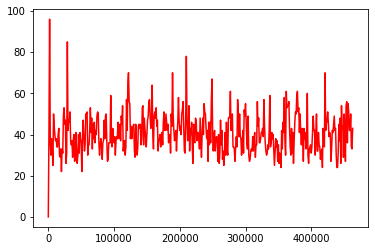

In [78]:
count_cov(bam_file_pacbio)

### 2. Nanopore

Запустим minimap2:
```
$ minimap2 --MD -a -t 4 data/reference.fasta data/ONT_2D.fastq.gz > data/ONT.sam
[M::mm_idx_gen::0.151*1.02] collected minimizers
[M::mm_idx_gen::0.226*1.97] sorted minimizers
[M::main::0.226*1.97] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.262*1.83] mid_occ = 11
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.274*1.80] distinct minimizers: 838533 (98.18% are singletons); average occurrences: 1.034; average spacing: 5.352
[M::worker_pipeline::22.101*3.42] mapped 30810 sequences
[M::main] Version: 2.17-r941
[M::main] CMD: /home/toharhymes/minimap2-2.17_x64-linux/minimap2 --MD -a -t 4 data/reference.fasta data/ONT_2D.fastq.gz
[M::main] Real time: 22.109 sec; CPU: 75.588 sec; Peak RSS: 1.062 GB

$ samtools flagstat data/ONT.sam
32103 + 0 in total (QC-passed reads + QC-failed reads)
1072 + 0 secondary
221 + 0 supplementary
0 + 0 duplicates
29565 + 0 mapped (92.09% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)
$ samtools view -S -b ONT.sam > ONT.bam

```

In [79]:
bam_file_ont = read_bam('data/ONT.bam')

Среднее покрытие: 28.316810344827587
Доля покрытия 1.0


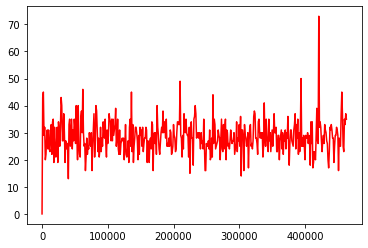

In [80]:
count_cov(bam_file_ont)